# Visualization

In [ ]:
import os
import json
import pickle

import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt

from zpinn.pinn_nf2_visualization import pinn_cube, draw_grid
from zpinn.pinn_nf2_cleanup import create_coordinates

In [ ]:
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "3"

In [ ]:
with open('config.json') as config:
    info = json.load(config)

input_path = info['input_path']
input_original = os.path.join(input_path, 'original')

b_path = os.path.join(input_original, "b.pickle")

with open(b_path,"rb") as f:
    b = pickle.load(f)

In [ ]:
bi = draw_grid(b.grid)

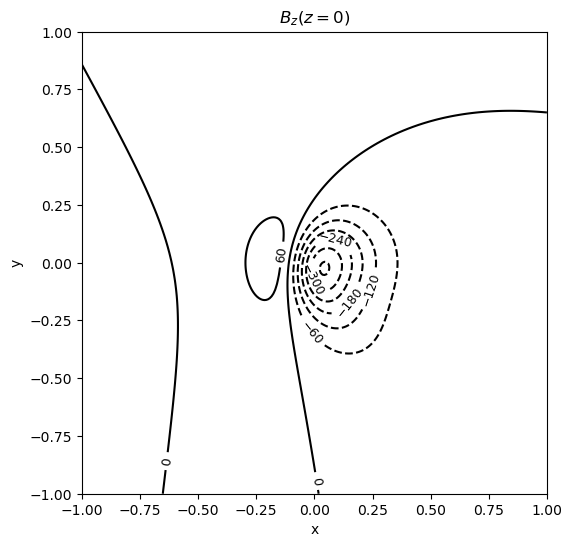

In [ ]:
bi.plt_Bz()

## PINN

In [ ]:
save_path = '/userhome/jeon_mg/workspace/zpinn/nbs/pinn/model_010000.pt'

In [ ]:
pinn = pinn_cube(save_path)

FileNotFoundError: [Errno 2] No such file or directory: '/userhome/jeon_mg/workspace/zpinn/nbs/pinn/model_010000.pt'

In [ ]:
pinn.state

{'iteration': 10000,
 'model': DataParallel(
   (module): BModel(
     (d_in): Linear(in_features=3, out_features=256, bias=True)
     (linear_layers): ModuleList(
       (0): Linear(in_features=256, out_features=256, bias=True)
       (1): Linear(in_features=256, out_features=256, bias=True)
       (2): Linear(in_features=256, out_features=256, bias=True)
       (3): Linear(in_features=256, out_features=256, bias=True)
       (4): Linear(in_features=256, out_features=256, bias=True)
       (5): Linear(in_features=256, out_features=256, bias=True)
       (6): Linear(in_features=256, out_features=256, bias=True)
       (7): Linear(in_features=256, out_features=256, bias=True)
     )
     (d_out): Linear(in_features=256, out_features=3, bias=True)
   )
 ),
 'cube_shape': (128, 128, 128),
 'b_norm': 100,
 'spatial_norm': 32,
 'loss_bc': array(0.00019339, dtype=float32),
 'w_bc': 63.09573444803282,
 'loss_div': array(0.0054698, dtype=float32),
 'w_div': 1,
 'loss_ff': array(0.02041501, dty

In [ ]:
pinn.calculate_magnetic_fields(batch_size=10000)

100%|██████████| 210/210 [00:01<00:00, 119.14it/s]


ImageData (0x7f2bf5eabac0)
  N Cells:      2048383
  N Points:     2097152
  X Bounds:     0.000e+00, 1.270e+02
  Y Bounds:     0.000e+00, 1.270e+02
  Z Bounds:     0.000e+00, 1.270e+02
  Dimensions:   128, 128, 128
  Spacing:      1.000e+00, 1.000e+00, 1.000e+00
  N Arrays:     2

In [ ]:
pi = draw_grid(pinn.grid)

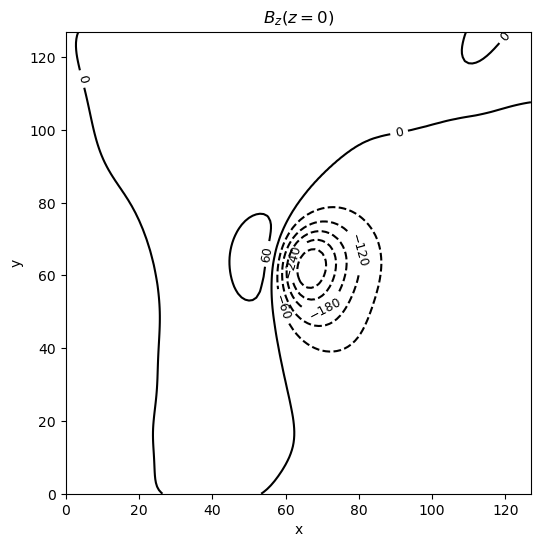

In [ ]:
pi.plt_Bz()

## SPINN

In [ ]:
result_path = 'spinn'
B_path = os.path.join(result_path, "B.pickle")

with open(B_path,"rb") as f:
    B = pickle.load(f)

In [ ]:
Bx = B[..., 0]
By = B[..., 1]
Bz = B[..., 2]

In [ ]:
with open('config.json') as config:
    info = json.load(config)

nx = info['nx']
ny = info['ny']
nz = info['nz']

In [ ]:
co_bounds = (0, nx-1, 0, ny-1, 0, nz-1)
co_coords = create_coordinates(co_bounds).reshape(-1, 3)
co_coord = co_coords.reshape(nx, ny, nz, 3)
x = co_coord[..., 0]
y = co_coord[..., 1]
z = co_coord[..., 2]
ggrid = pv.StructuredGrid(x, y, z)
vectors = np.stack([Bx, By, Bz], axis=-1).transpose(2, 1, 0, 3).reshape(-1, 3)
ggrid['B'] = vectors
ggrid.active_vectors_name = 'B'
magnitude = np.linalg.norm(vectors, axis=-1)
ggrid['mag'] = magnitude
ggrid.active_scalars_name = 'mag'

ggrid

StructuredGrid (0x7f33d05d8e20)
  N Cells:      16581375
  N Points:     16777216
  X Bounds:     0.000e+00, 2.550e+02
  Y Bounds:     0.000e+00, 2.550e+02
  Z Bounds:     0.000e+00, 2.550e+02
  Dimensions:   256, 256, 256
  N Arrays:     2

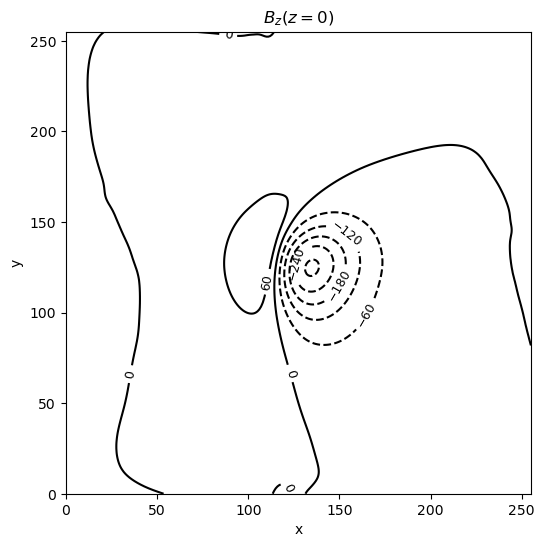

In [ ]:
aaa = draw_grid(ggrid)
aaa.plt_Bz()